# Performing GPU Batch Prediction on Images with a PyTorch Model

In this example, we will introduce how to use the Ray AIR {class}`BatchPredictor <ray.train.batch_predictor.BatchPredictor>` for **large-scale batch inference with multiple GPU workers.**

In particular, we will:
- Load Imagenette dataset from S3 bucket and create a ray dataset.
- Load a pretrained ResNet model and build a checkpoint.
- Define a preprocessor.
- Construct a BatchPredictor with the checkpoint and preprocessor.
- Do batch prediction on multiple GPUs.
- Evaluate the predictions and save results to S3/local disk.

To run this example, you will need to install the following:

In [ ]:
!pip install -q "ray[air]" boto3 torch torchvision

[Imagenette](https://github.com/fastai/imagenette) is a subset of Imagenet with 10 classes. First, we use {meth}`ray.data.read_images <ray.data.read_images>` to load the validation set from S3. Since the dataset is already structured with directory names as the labels, we can use the {class}`Partitioning <ray.data.datasource.Partitioning>` API to automatically extract image labels.

In [1]:
import ray
from ray.data.datasource.partitioning import Partitioning

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/val/"

# The S3 directory structure is {s3_uri}/{class_id}/{*.JPEG}
partitioning = Partitioning("dir", field_names=["class"], base_dir=s3_uri)

ds = ray.data.read_images(
    s3_uri, size=(256, 256), partitioning=partitioning, mode="RGB"
)
ds


2023-02-21 12:00:38,004	INFO worker.py:1360 -- Connecting to existing Ray cluster at address: 10.0.32.131:6379...
2023-02-21 12:00:38,036	INFO worker.py:1553 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 
2023-02-21 12:00:38,716	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_96e1aec9dfd1038398d7730304a88380.zip' (228.83MiB) to Ray cluster...
2023-02-21 12:00:43,539	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_96e1aec9dfd1038398d7730304a88380.zip'.


In [12]:
ds.take(1)


[{'image': array([[[126, 144, 157],
          [129, 147, 161],
          [132, 149, 163],
          ...,
          [ 92, 105, 106],
          [ 95, 107, 110],
          [ 96, 109, 110]],
  
         [[124, 142, 156],
          [126, 145, 159],
          [130, 147, 161],
          ...,
          [ 89,  99, 101],
          [ 90, 102, 105],
          [ 92, 105, 106]],
  
         [[121, 140, 155],
          [126, 144, 159],
          [130, 147, 161],
          ...,
          [ 85,  98,  99],
          [ 87, 101, 102],
          [ 90, 101, 103]],
  
         ...,
  
         [[183, 184, 177],
          [183, 184, 178],
          [182, 184, 174],
          ...,
          [ 88,  98,  45],
          [ 97,  94,  47],
          [ 79,  92,  41]],
  
         [[180, 181, 171],
          [179, 181, 173],
          [180, 182, 171],
          ...,
          [ 89,  72,  29],
          [ 79, 106,  50],
          [ 66,  87,  30]],
  
         [[177, 178, 168],
          [179, 181, 169],
          [180,

As we can see, each example contains one image tensor of shape (256, 256, 3) and its label. Notice that the label for images are their corresponding directory names (e.g. n01728920). To find the indices of our model output that correspond to these names, we'll need to download a mapping from the s3 bucket (`imagenet_class_index.json`).

In [2]:
# If you want to run the full example, please set this to False
SMOKE_TEST = True


In [3]:
# @title +
if SMOKE_TEST:
    ds = ds.limit(1000)


In [3]:
import json
import boto3
from botocore import UNSIGNED
from botocore.client import Config

# Download mapping file from S3
s3 = boto3.client("s3", config=Config(signature_version=UNSIGNED))
s3.download_file(
    "air-example-data-2",
    "imagenette2/imagenet_class_index.json",
    "/tmp/imagenet_class_index.json",
)

# Build mappings
idx_to_class = json.load(open("/tmp/imagenet_class_index.json", "r"))
class_to_idx = {cls_name: int(index) for index, (cls_name, _) in idx_to_class.items()}
idx_to_class_name = {int(index): text for index, (_, text) in idx_to_class.items()}


Next, let's define a preprocessor to crop and normalize images, as well as convert the class names to indices with the map that we just constructed. 

We'll use a {class}`TorchVisionPreprocessor <ray.data.preprocessors.TorchVisionPreprocessor>` and a {class}`BatchMapper <ray.data.preprocessors.BatchMapper>` to implement these two custom preprocessing logic accordingly. Multiple preprocessors will be combined into a single preprocessor by {class}`Chain <ray.data.preprocessors.Chain>`. The above data preprocessing logic will be applied to the input dataset before feeding the data into the model.

In [4]:
import torch
import numpy as np
import pandas as pd
from torchvision import transforms
from ray.data.preprocessors import BatchMapper, TorchVisionPreprocessor, Chain
from typing import Dict


def to_tensor(batch: np.ndarray) -> torch.Tensor:
    tensor = torch.as_tensor(batch, dtype=torch.float)
    # (B, H, W, C) -> (B, C, H, W)
    tensor = tensor.permute(0, 3, 1, 2).contiguous()
    # [0., 255.] -> [0., 1.]
    tensor = tensor.div(255)
    return tensor


transform = transforms.Compose(
    [
        transforms.Lambda(to_tensor),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Accelerate image processing with batched transformations
image_preprocessor = TorchVisionPreprocessor(
    columns=["image"], transform=transform, batched=True
)

# Map the image labels from strings to integer ids
def map_labels(batch: np.ndarray) -> np.ndarray:
    batch["label"] = np.vectorize(class_to_idx.__getitem__)(batch["class"])
    return batch


label_preprocessor = BatchMapper(fn=map_labels, batch_format="numpy")

preprocessor = Chain(image_preprocessor, label_preprocessor)


## Build a BatchPredictor

Now that we have our dataset loaded and preprocessed with [Ray Data](data), we're ready to construct our {class}`BatchPredictor <ray.train.batch_predictor.BatchPredictor>`! A {class}`BatchPredictor <ray.train.batch_predictor.BatchPredictor>` takes a checkpoint and a predictor class (e.g., {class}`~ray.train.torch.TorchPredictor`, {class}`~ray.train.tensorflow.TensorflowPredictor`) and provides an interface to run batch prediction on Ray {class}`~ray.data.Datastream`s. It will distribute the inference workload across multiple workers when calling `predict()` and run prediction on multiple shards of data in parallel. You can find more details in [Using Predictors for Inference](air-predictors).

For the demo, we'll directly load a pretrained ResNet model from `torchvision.models` and construct a {class}`~ray.train.torch.TorchCheckpoint` which includes the preprocessor. You can also load your own Ray AIR checkpoint from your previous Train/Tune experiments. You can find more details about checkpoint loading at the [AIR `Checkpoint` API reference](air-checkpoint-ref).

In [ ]:
from torchvision import models
from ray.train.batch_predictor import BatchPredictor
from ray.train.torch import TorchCheckpoint, TorchPredictor

# Load the pretrained resnet model and construct a checkpoint
model = models.resnet152(pretrained=True)
checkpoint = TorchCheckpoint.from_model(model=model, preprocessor=preprocessor)

# Build a BatchPredictor from checkpoint
batch_predictor = BatchPredictor(checkpoint, TorchPredictor)


Finally, run batch prediction using {meth}`BatchPredictor.predict(...) <ray.train.batch_predictor.BatchPredictor.predict>`!

In [11]:
predictions = batch_predictor.predict(
    ds,
    feature_columns=["image"],
    keep_columns=["label"],
    batch_size=128,
    max_scoring_workers=3,
    num_gpus_per_worker=1,
)


2023-02-21 12:19:58,856	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[read->TorchVisionPreprocessor]
read->TorchVisionPreprocessor: 100%|██████████| 200/200 [00:09<00:00, 21.74it/s]
2023-02-21 12:20:08,165	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[BatchMapper]
BatchMapper: 100%|██████████| 200/200 [00:01<00:00, 105.07it/s]
2023-02-21 12:20:10,181	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> ActorPoolMapOperator[MapBatches(ScoringWrapper)]
MapBatches(ScoringWrapper), 0 actors [6 locality hits, 28 misses]:  17%|█▋        | 34/200 [00:20<01:38,  1.69it/s]


We specified several parameters in `predict()`:
- `feature_columns` specifies which columns are required for the model.
- The columns in `keep_columns` will be returned together with the prediction results. For example, you can keep image labels for evaluation later.
- The BatchPredictor uses CPUs for inference by default, please specify `num_gpus_per_worker` if you want to use GPUs.

## Evaluating Prediction Accuracy

`BatchPredictor.predict()` will return a Datastream with a column of model output with key `"predictions"`, and all columns specified in `keep_columns`.

In this example, the output of the ResNet model is a 1000-dimensional tensor containing the logits of each class. We'll measure accuracy with Top-1 and Top-5 accuracy.
(Top-N accuracy: The percentage of predictions where the true label falls in the top N predicted classes.)

In [8]:
def calculate_matches(batch: pd.DataFrame) -> pd.DataFrame:
    batch["top_5_pred"] = batch["predictions"].apply(lambda x: np.argsort(-x)[:5])
    batch["top_5_pred_name"] = batch["top_5_pred"].map(
        lambda x: [idx_to_class_name[idx] for idx in x]
    )
    batch["top_5_match"] = batch.apply(lambda x: x["label"] in x["top_5_pred"], axis=1)
    batch["top_1_match"] = batch.apply(
        lambda x: x["label"] == x["top_5_pred"][0], axis=1
    )
    return batch


predictions = predictions.map_batches(calculate_matches, batch_format="pandas")
print("Top-1 accuracy: ", predictions.mean(on="top_1_match"))
print("Top-5 accuracy: ", predictions.mean(on="top_5_match"))


2023-02-21 12:19:27,478	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(calculate_matches)] -> AllToAllOperator[aggregate]
MapBatches(calculate_matches): 100%|██████████| 34/34 [00:00<00:00, 1019.05it/s]
2023-02-21 12:19:27,541	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[MapBatches(calculate_matches)]
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 52.32it/s]


Top-1 accuracy:  0.8968152866242038


2023-02-21 12:19:27,670	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[aggregate]
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00, 70.82it/s]


Top-5 accuracy:  0.9887898089171975


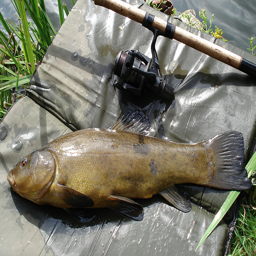

Top-1 Matched:  True
Top-5 Predictions:  ['tench', 'reel', 'coho', 'barracouta', 'gar']


In [9]:
from IPython.display import display
from PIL import Image

# Take an example from the model's prediction
sample_image = ds.take(1)[0]
sample_pred = predictions.take(1)[0]
display(Image.fromarray(sample_image["image"]))
print("Top-1 Matched: ", sample_pred["top_1_match"])
print("Top-5 Predictions: ", sample_pred["top_5_pred_name"])


## Save Prediction Results

There are a few options for saving your prediction results:
- You can call `ds.repartition(n)` to split your prediction results into n partitions, then n files will be created with `write_parquet()` later.
- You can either store files to your local disk or S3 bucket by passing local path or S3 uri to `write_parquet()`.
- Other output file formats are described here: [Ray Data Input/Output](https://docs.ray.io/en/latest/data/api/input_output.html)


In [10]:
predictions.repartition(1).write_parquet("local://tmp/single_parquet")
# >>> /tmp/single_parquet/d757569dfb2845589b0ccbcb263e8cc3_000000.parquet

predictions.repartition(3).write_parquet("local://tmp/multiple_parquet")
# >>> /tmp/multiple_parquet/2b529dc5d8eb45e5ad03e69fb7ad8bc0_000000.parquet
# >>> /tmp/multiple_parquet/2b529dc5d8eb45e5ad03e69fb7ad8bc0_000001.parquet
# >>> /tmp/multiple_parquet/2b529dc5d8eb45e5ad03e69fb7ad8bc0_000002.parquet

# You can also save results to S3 by replacing local path to S3 URI
# predictions.write_parquet(YOUR_S3_BUCKET_URI)


2023-02-21 12:19:39,798	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[repartition] -> TaskPoolMapOperator[write]
write: 100%|██████████| 1/1 [00:00<00:00, 10.46it/s]
2023-02-21 12:19:39,989	INFO bulk_executor.py:41 -- Executing DAG InputDataBuffer[Input] -> AllToAllOperator[repartition] -> TaskPoolMapOperator[write]
write: 100%|██████████| 3/3 [00:00<00:00, 46.64it/s]
